# Rotten Tomatoes Sentiment Prediction
This notebook describes the models that Anne LoVerso and Casey Alvarado used to predict the sentiment for movie reviews. We downloaded data from the Kaggle Movie Review Sentiment, [Kaggle Movie Review Sentiment](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews), and used the provided reviews and sentiment to to predict the sentiment for each phrase.  The Kaggle data gives us a series of sentences and their corresponding sentiment value on the following scale:
- 0: very negative
- 1: somewhat negative
- 2: neutral
- 3: somewhat positive
- 4: very positive

The sentences are also broken down into chunks of phrases that make up each sentence, and the sentiment of each phrase that makes up a sentence.

## Exploration
- sentence sentiment vs average sentiment of its phrases

- pattern sentiment (but minimize)
- subj/obj and phrase length
- modality and mood (summarize all the pattern stuff bc we didn't really use it)

- figure out what word2vec does - if it's similar to nltk tagging then include that

- WORD CLOUD
- include most pos/neg words (relate to naive bayes + flow into scikit learn)

## Classification Models
- copy the model-iterations notebook but clean the code to make sure it isn't repetitive

## Neural Networks
- Code from lasagne and results
- add lots of comments to show we know what it does

# Intro Code
This code that creates the data and testdata pandas dataframe, and a function that makes a Kaggle submission file, both get used consistently throughout the file, so both of these should be compiled at the beginning.

In [66]:
import numpy as np 
import pandas 
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, 'ThinkStats2')
import thinkstats2
%matplotlib inline

data = pandas.read_csv('train.tsv', sep = '\t') 
testdata = pandas.read_csv('test.tsv', sep = '\t') 

In [2]:
def make_submission(predictions, filename):
    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pandas.DataFrame({
            "PhraseId": testdata["PhraseId"],
            "Sentiment": predictions
        })
    submission.to_csv(filename, index=False)

# Exploration

The movie reviews contained both the whole sentences and the segements of these sentences that made up these sentences. As well as the sentiment value for all of this phrases. First, we were curious to find out of there was a correlation between the sentiment value of the sentence as a whole and the averaged sentiment of the sentence segments. How close are the average sentement value of the segments in comparison to the sentiment of the sentence as a whole?
We averaged all the sentiment of the segments that corresponded to each sentence, as indicated by the sentence id. Then compared that number to the sentiment of the sentence as a whole. 

In [23]:
# acquire all of the sentence ids, just once into a list. 
#This will help us iterate through the phrases to find all of the phrases that correspond to each sentence id. 

sentenceIds = list(set(data.SentenceId))

In [8]:
sentenceSentiments = []
phraseMeans = []

# The following loop will do the following for each sentence id: 
#find every segment that corresponds to the sentence id,take the mean sentiments of all of the phrases, and append to phraseMeans
#find the sentence that belongs to the sentence id, find sentiment, and append to sentenceSentiments

for i in sentenceIds: 
    phraseSents = data.Sentiment[data.PhraseId[data.SentenceId == i]]
    mean = phraseSents[2:len(phraseSents)].mean(); 
    phraseMeans.append(mean)
    sentenceSentiments.append(data.Sentiment[data.SentenceId == i].iloc[0])

In [ ]:
thinkplot.Scatter(sentenceSentiments, phraseMeans)
thinkplot.Show(xlabel = 'sentiment of sentence', ylabel = 'mean of all phrase sentiments', title = 'scatter plot of sentiment and phrase sentiment mean')

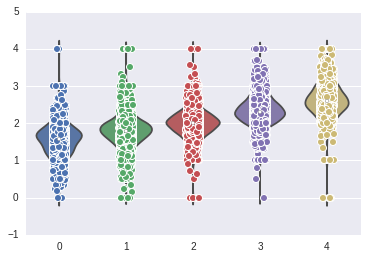

In [63]:
# print (sentenceSentiments) 
# print (phraseMeans)

ax = sns.stripplot(x=sentenceSentiments, y=phraseMeans, jitter = True, order = [0, 1, 2, 3, 4])
sns.violinplot(x=sentenceSentiments, y=phraseMeans, order = [0, 1, 2, 3, 4])

The graph above shows us that there is a positive correlation between the sentiment of the sentence and the average mean of the segments. The vertical lines seem to be increasing, this is because sentiment is also increasing so the mean of phrases with higher sentiments would also increase. This scatter plot also shows that the mean is closests to 2 when sentiment is around 2. The violin plot helps show the concentation of the mean sentiment values. It looks like these concentrations are increasing linearly. More importantly, notice that the concentrations for each sentiment value is not around the sentence sentiment value. For example, for sentence sentiment = 1, the concentration of the average phrase sentiment looks to be around 2. 
We can use thinkstats2's cross correlation function to calculate how dependent these two data sets are on each other and therefore, tell us the magnitude of the correlation.  

There are two main correlations that we can take that will give us an idea of how these two datasets are related: 
1. The Pearson Correlation transforms each value into a standard score. Then calculates how far away from the mean is each standard score. This correlation ranks them according to how far they are from the mean.  This value is usually between -1 and +1. If this number is positive, then we can say that when one dataset is high, then the other data set will also be high. If the correlation value is -1 or 1, then the two series are perfectly correlated, which means if we know one then we know the other. 
2. The Spearman Correlation ranks each value and returns the index. This correlation type is better for nonlinear values and outliers. 

In [87]:
#converting these into pandas series to work with the correlation function. 
#Cleaning the phraseMeans series dataframe because taking the mean produced some not a number entries.
sentenceSentiments = pandas.Series(sentenceSentiments)
phraseMeans = pandas.Series(phraseMeans).fillna(2.0)

In [88]:
#calling the correlation functions
pearson_l_m = thinkstats2.Corr(sentenceSentiments, phraseMeans)
spearman_l_m = thinkstats2.SpearmanCorr(sentenceSentiments, phraseMeans)
print pearson_l_m
print spearman_l_m

0.633769287721
0.683130561304


The Pearson correlation and the Spearman correlation values are close in magnitude and positive. This means that there is a strong correlation between the sentiment value and the mean of the segment phrases sentiment value. Therefore, if we know one, we can make an educated guess about the other that will likely be close enough. The mean sentiment per phrase to be super far off from the sentiment of the sentence.

# Classification Models
This section describes Anne and Casey's first attempt at building models for [Kaggle Movie Review Sentiment](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).  We decided that for a first iteration, we would try a lot of different models based on research that we had done, learning as much as we could while seeing what would work the best.

The sections are:
- Naive Bayes Classifier
    - implemented by hand
    - using sklearn MultinomialNB
    - using NLTK
- sklearn Pipeline with a variety of estimators
- Using Logistic Regression

# Neural Networks with Lasagne
This section describes our work with implementing a neural network in using the  [Lasagne](https://github.com/Lasagne/Lasagne) package.  Our code for this is heavily based off the [Lasagne MNIST tutorial](http://lasagne.readthedocs.org/en/latest/user/tutorial.html) and we used their method of implementing a Multi-Layer Perceptron model and training it on our particular dataset.

## Word2Vec
We loaded data into our network using word2vec encodings of our original phrase data.  The word2vec algorithm by Google used billions of Google news data sources to train a model that basically provides a lookup table for an enormous vocabulary.  The idea is that for the words, it would be able to provide a 300-dimensional vector of features that represents the various semantic properties of a word.  This vector could then be used to predict similar words or words that are likely to succeed other words.

In using word2vec in our encodings, we are able to use it as a lookup table.  Our training data has the shape (68030, 300) because we have 68030 phrases.  For each phrase, word2vec was used on each word to generate a 300-dimensional vector of features for the word.  Then, the vectors for all words in a phrase were averaged together to yield a single 1x300 vector for a phrase that represented the average semantic encoding of the phrase.  This was done for all 68030 phrases to give us the final dense matrix of 68030 rows and 300 columns.

In [8]:
import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T
import lasagne
import pandas 
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import LabelShuffleSplit

In [3]:
def load_dataset():

    # load the training data using pickle
    # the data X has shape (68030, 300) and is the average word2vec semantic encodings for each phrase
    # the data y has shape (68030,) and is the sentiment for each phrase from 0-4
    f = open('rotten_tomatoes_train.pickle')
    X = pickle.load(f)
    y = pickle.load(f)
    f.close()
    
    def make_splits(X,y):
        splits = LabelShuffleSplit(data.SentenceId, test_size=0.5, n_iter=1)
        for train_indices, test_indices in splits:
            X_train = X[train_indices,:]
            y_train = y[train_indices]
            X_test = X[test_indices, :]
            y_test = y[test_indices]
            return X_train, X_test, y_train, y_test

    # make train_test_split on the sentenceID
    X_train, X_test, y_train, y_test = make_splits(X,y)
    
    # we used sklearn's train_test_split to separate 50% of our data as test data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

    # We reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # we return all the arrays (in np.asarray format, so that it is compatible with theano)
    return np.asarray(X_train), np.asarray(y_train), np.asarray(X_val), np.asarray(y_val), np.asarray(X_test), np.asarray(y_test)

## The MLP
The following function builds a Multi-Layer Perceptron model for our neural network.  Based on our research, an MLP as we understand it is a way to expand upon Logistic Regression by adding one or more hidden layers.  The input layer maps to the hidden layer through a set of weights that are learned, and then it maps from the final hidden layer to a set of outputs through another set of learned weights.

Our MLP has two hidden layers of 800 units each.  It applies 50% dropout following each hidden layer and 20% dropout to the initial input.  It ends up with a softmax output layer with 5 units, for the 5 classes of sentiment in our data.  The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is a form of normalized logistic regression (that is necessary in neural networks) but that is commonly used in multiclass classification such as this problem.  The specifications of the network and each layer are based on the Lasagne tutorial.

A representation of the layers of our MLP network is:

Input | 20% dropout | Hidden layer 1 | 50% dropout | Hidden layer 2 | 50% dropout | Output layer (5)

In [4]:
def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 5 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 300),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 5 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=5,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out


## Minibatch Iterator
This section (again, using code from teh Lasagne tutorial) creates a helper function that, using yield, returns an iterable generator object that allows us to create batches from our full input data (either randomized or sequential depending on the shuffle variable).  This function gets used in the training of our model and the train function that we define is performed on each minibatch, and the loss for each epoch is the sum of the loss for each batch within the epoch.

In [ ]:
# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == len(targets)
    print (inputs.shape[0])
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

## Main Training
The training of the model uses 500 epochs and trains in minibatches on each epoch.

Before training, we create the loss and update functions.  The update function uses Stochastic Gradient Descent.  The error for each phrase and sentiment value can be calculated, and then we need the gradient of the error, and we want to sum all these gradients for all data points.  This is computationally expensive so instead it chooses a random x,y pair (in our case, a phrase and corresponding sentiment value) to calculate the gradient and moves along the curve relative to the error of the previous point so that it can move more finely when necessary.  Lasagne implements this algorithm for us.

The loss function uses [categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression), which calculates a measure of similarity between the prediction for a given data point and its actual value.  This is one of many loss functions that Lasagne provides, and we chose to use it based on the tutorial example.

In [ ]:
# define number of epochs to train for
num_epochs=500

# Load the dataset
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_val = y_val.astype(np.int32)

# Prepare Theano variables for inputs and targets
# input_var is a matrix because it will be 2-dimensional (68030,300)
# and target_var is a vector because it will be 1-dimensional (68030,)
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

# Create neural network model
print("Building model and compiling functions...")
network = build_mlp(input_var)

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)

test_loss = test_loss.mean()

# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

# this function will be used to predict on our actual test data to make a Kaggle submission
pred_fn = theano.function([input_var], test_prediction)

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
        inputs, targets = batch
        a = train_fn(inputs, targets) #a is the loss returned by train_fn
        train_err += a
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

# dump the network weights to a file like this:
np.savez('model3.npz', *lasagne.layers.get_all_param_values(network))


## Make Predictions
This code uses the trained network to make predictions and create a Kaggle submission file

In [16]:
# make predictions and submission

# Prepare Theano variables for inputs and targets
input_var = T.matrix('inputs')
target_var = T.ivector('targets')

network = build_mlp(input_var)

# load the model
with np.load('model2.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

test_prediction = lasagne.layers.get_output(network, deterministic=True)

pred_fn = theano.function([input_var], test_prediction)

# load the test data
f = open('X_test_word2vec.pickle')
X_testdata = pickle.load(f)
f.close()

# make predictions!
pred_probabilities = pred_fn(X_testdata)

predictions = list(map(lambda pr: list(pr).index(max(pr)), pred_probabilities))

make_submission(predictions, "neural2.csv")